In [ ]:
!pip install dask-expr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: dask
    Found existing installation: dask 2024.7.1
    Uninstalling dask-2024.7.1:
      Successfully uninstalled dask-2024.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.8.2 which is incompatible.


In [ ]:

import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [ ]:
# 파일 호출
data_path: str = "/content/drive/MyDrive/AITech/W6_7_ML_Basic_PJ/data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [ ]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할당
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 29.28it/s]


# EDA

In [ ]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

,0
hourly_market-data_liquidations_okex_all_symbol_short_liquidations,100.0
hourly_market-data_liquidations_okex_btc_usdt_short_liquidations_usd,100.0
hourly_market-data_liquidations_okex_btc_usdt_short_liquidations,100.0
hourly_market-data_liquidations_okex_btc_usdt_long_liquidations,100.0
hourly_market-data_funding-rates_okex_funding_rates,100.0
...,...
target,0.0
hourly_market-data_open-interest_htx_global_all_symbol_open_interest,0.0
hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,0.0
hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,0.0


In [ ]:
eda_df.head()

,ID,target,_type,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_btc_usdt_long_liquidations,...,hourly_market-data_taker-buy-sell-stats_okex_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_okex_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_okex_taker_buy_sell_ratio,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_sell_ratio,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume
0,2023-01-01 00:00:00,2.0,train,0.01,0.01,0.012,0.000,197.51610,0.00000,0.0,...,NaN,NaN,NaN,377290.0,252550.0,0.599025,0.400975,1.493922,16536.747967,5516.420322
1,2023-01-01 01:00:00,1.0,train,0.01,0.01,0.000,0.712,0.00000,11833.56104,0.0,...,NaN,NaN,NaN,463720.0,116960.0,0.798581,0.201419,3.964774,16557.136536,4513.341881
2,2023-01-01 02:00:00,1.0,train,0.01,0.01,0.000,0.000,0.00000,0.00000,0.0,...,NaN,NaN,NaN,172790.0,603920.0,0.222464,0.777536,0.286114,16548.149805,4310.904314
3,2023-01-01 03:00:00,1.0,train,0.01,0.01,0.593,0.000,9754.76891,0.00000,0.0,...,NaN,NaN,NaN,176450.0,199630.0,0.469182,0.530818,0.883885,16533.632875,4893.417864
4,2023-01-01 04:00:00,2.0,train,0.01,0.01,0.361,0.000,5944.43714,0.00000,0.0,...,NaN,NaN,NaN,130040.0,377920.0,0.256004,0.743996,0.344094,16524.712159,5209.002297


In [ ]:
eda_df.iloc[:,:50].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 50 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   ID                                                                              8760 non-null   object 
 1   target                                                                          8760 non-null   float64
 2   _type                                                                           8760 non-null   object 
 3   hourly_market-data_funding-rates_binance_funding_rates                          8760 non-null   float64
 4   hourly_market-data_funding-rates_bybit_funding_rates                            8729 non-null   float64
 5   hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations       8760 non-null   float64
 6   hourly_market-data_li

In [26]:
# 시각화용 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# MARKET-DATA에서의 특정 변수만 포함한 데이터프레임 subset 생성
eda_columns = ['ID',
               'target',
               '_type',
               'hourly_market-data_coinbase-premium-index_coinbase_premium_gap',
               'hourly_market-data_coinbase-premium-index_coinbase_premium_index',
               'hourly_market-data_funding-rates_binance_funding_rates',
               'hourly_market-data_funding-rates_bybit_funding_rates',
               'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
               'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
               'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
               'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd'
               ]

eda_subset = eda_df[eda_columns]

In [19]:
# 확인
eda_subset.head(2)

,ID,target,_type,hourly_market-data_coinbase-premium-index_coinbase_premium_gap,hourly_market-data_coinbase-premium-index_coinbase_premium_index,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,-9.86,-0.059650,0.01,0.01,0.012,0.000,197.5161,0.00000
1,2023-01-01 01:00:00,1.0,train,-8.78,-0.053047,0.01,0.01,0.000,0.712,0.0000,11833.56104


In [21]:
# 칼럼명 확인
eda_subset.columns

Index(['ID', 'target', '_type',
       'hourly_market-data_coinbase-premium-index_coinbase_premium_gap',
       'hourly_market-data_coinbase-premium-index_coinbase_premium_index',
       'hourly_market-data_funding-rates_binance_funding_rates',
       'hourly_market-data_funding-rates_bybit_funding_rates',
       'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
       'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
       'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd'],
      dtype='object')

In [22]:
# 가독성 있게 칼럼명 변경
eda_subset.rename(columns={
    'hourly_market-data_coinbase-premium-index_coinbase_premium_gap': 'cb_premium_gap',
    'hourly_market-data_coinbase-premium-index_coinbase_premium_index': 'cb_premium_index',
    'hourly_market-data_funding-rates_binance_funding_rates': 'binance_funding_rate',
    'hourly_market-data_funding-rates_bybit_funding_rates': 'bybit_funding_rate',
    'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations': 'long_liq_count',
    'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations': 'short_liq_count',
    'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd': 'long_liq_usd',
    'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd': 'short_liq_usd'
}, inplace=True)

<ipython-input-22-2cac830e8c45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_subset.rename(columns={


In [24]:
# 수정된 칼럼명 확인 
eda_subset.head()

,ID,target,_type,cb_premium_gap,cb_premium_index,binance_funding_rate,bybit_funding_rate,long_liq_count,short_liq_count,long_liq_usd,short_liq_usd
0,2023-01-01 00:00:00,2.0,train,-9.86,-0.059650,0.01,0.01,0.012,0.000,197.51610,0.00000
1,2023-01-01 01:00:00,1.0,train,-8.78,-0.053047,0.01,0.01,0.000,0.712,0.00000,11833.56104
2,2023-01-01 02:00:00,1.0,train,-9.59,-0.057952,0.01,0.01,0.000,0.000,0.00000,0.00000
3,2023-01-01 03:00:00,1.0,train,-9.74,-0.058912,0.01,0.01,0.593,0.000,9754.76891,0.00000
4,2023-01-01 04:00:00,2.0,train,-10.14,-0.061373,0.01,0.01,0.361,0.000,5944.43714,0.00000


### Target 변수 EDA 

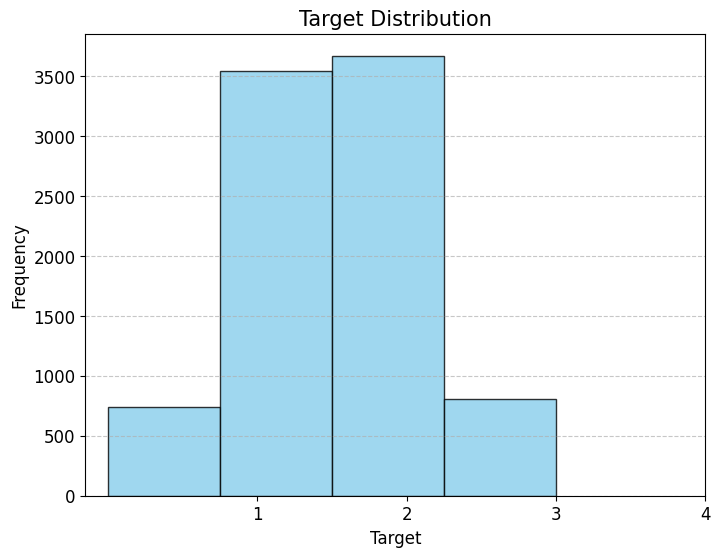

In [28]:
# Target Distribuion 히스토그램 
plt.figure(figsize=(8, 6))
plt.hist(eda_subset['target'], bins=4, edgecolor='black', color='skyblue', alpha=0.8)
plt.title('Target Distribution', fontsize=15)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([1, 2, 3, 4], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

* **대칭**
* 데이터 불균형이 딱히 발견되지 않음 
    * 상승장/하락장 경향성은 딱히 발견되지 않음

<ipython-input-33-3922e77886cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_subset['target_grouped'] = eda_subset['target'].apply(lambda x: 'Group 1 (0 & 1)' if x in [0.0, 1.0] else 'Group 2 (2 & 3)')


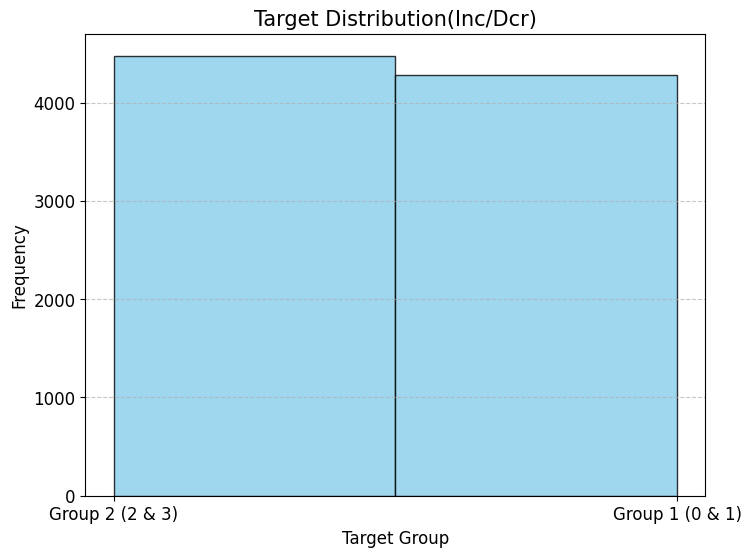

In [33]:
eda_subset['target_grouped'] = eda_subset['target'].apply(lambda x: 'Group 1 (0 & 1)' if x in [0.0, 1.0] else 'Group 2 (2 & 3)')
plt.figure(figsize=(8, 6))
plt.hist(eda_subset['target_grouped'], bins=2, edgecolor='black', color='skyblue', alpha=0.8)
plt.title('Target Distribution(Inc/Dcr)', fontsize=15)
plt.xlabel('Target Group', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(['Group 1 (0 & 1)', 'Group 2 (2 & 3)'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


* +/-라는 상위 범주로 묶어도 마찬가지

### Univariate EDA

In [35]:
# ID 칼럼 Dtype확인
eda_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    8760 non-null   object 
 1   target                8760 non-null   float64
 2   _type                 8760 non-null   object 
 3   cb_premium_gap        8755 non-null   float64
 4   cb_premium_index      8755 non-null   float64
 5   binance_funding_rate  8760 non-null   float64
 6   bybit_funding_rate    8729 non-null   float64
 7   long_liq_count        8760 non-null   float64
 8   short_liq_count       8760 non-null   float64
 9   long_liq_usd          8760 non-null   float64
 10  short_liq_usd         8760 non-null   float64
 11  target_grouped        8760 non-null   object 
dtypes: float64(9), object(3)
memory usage: 1.1+ MB


#### Date - Coinbase Premium

<ipython-input-38-8e1a8cedfeb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_subset['ID'] = pd.to_datetime(eda_subset['ID'])


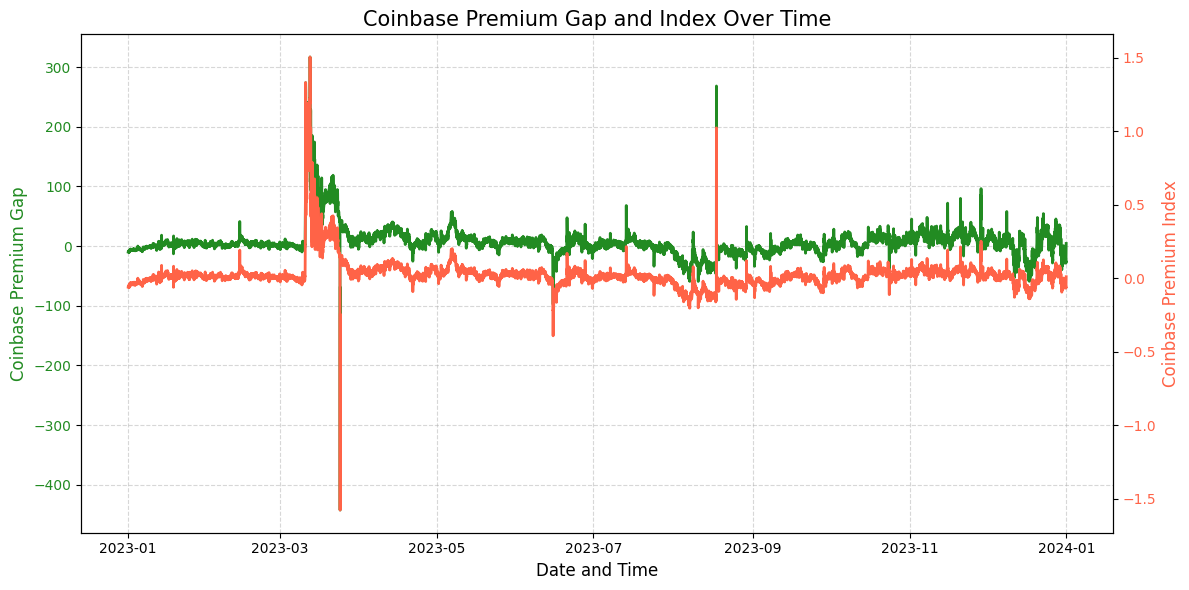

In [38]:
eda_subset['ID'] = pd.to_datetime(eda_subset['ID']) # 시계열 분석에 알맞게 변수타입 변경

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(eda_subset['ID'], eda_subset['cb_premium_gap'], color='forestgreen', label='Coinbase Premium Gap', linewidth=2)
ax1.set_xlabel('Date and Time', fontsize=12)
ax1.set_ylabel('Coinbase Premium Gap', color='forestgreen', fontsize=12)
ax1.tick_params(axis='y', labelcolor='forestgreen')
ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(eda_subset['ID'], eda_subset['cb_premium_index'], color='tomato', label='Coinbase Premium Index', linewidth=2)
ax2.set_ylabel('Coinbase Premium Index', color='tomato', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tomato')

plt.title('Coinbase Premium Gap and Index Over Time', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

* 2023년도 3월 근처에서 거래량, 종가 그래프때와 마찬가지로 큰 변동폭 
    * 아웃라이어로 간주해 제거하는 게 모델의 일반화성능에 더 도움이 될 수도 
    * 아웃라이어의 기준 설정에 유의

#### Date - Funding Rates

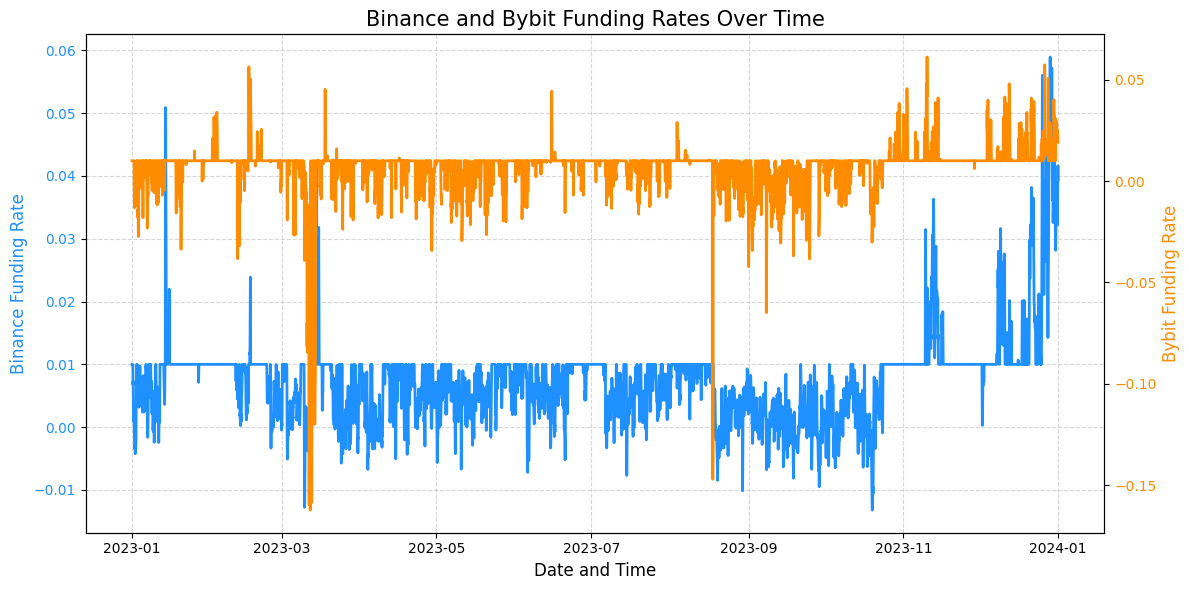

In [41]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(eda_subset['ID'], eda_subset['binance_funding_rate'], color='dodgerblue', label='Binance Funding Rate', linewidth=2)
ax1.set_xlabel('Date and Time', fontsize=12)
ax1.set_ylabel('Binance Funding Rate', color='dodgerblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(eda_subset['ID'], eda_subset['bybit_funding_rate'], color='darkorange', label='Bybit Funding Rate', linewidth=2)
ax2.set_ylabel('Bybit Funding Rate', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Binance and Bybit Funding Rates Over Time', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


* 아직 이해하지 못한 부분이 많은 플랏. 도메인 지식 더 필요 
* 다른 형태로 시각화 해볼 것 


#### Date - Liquidation Count 

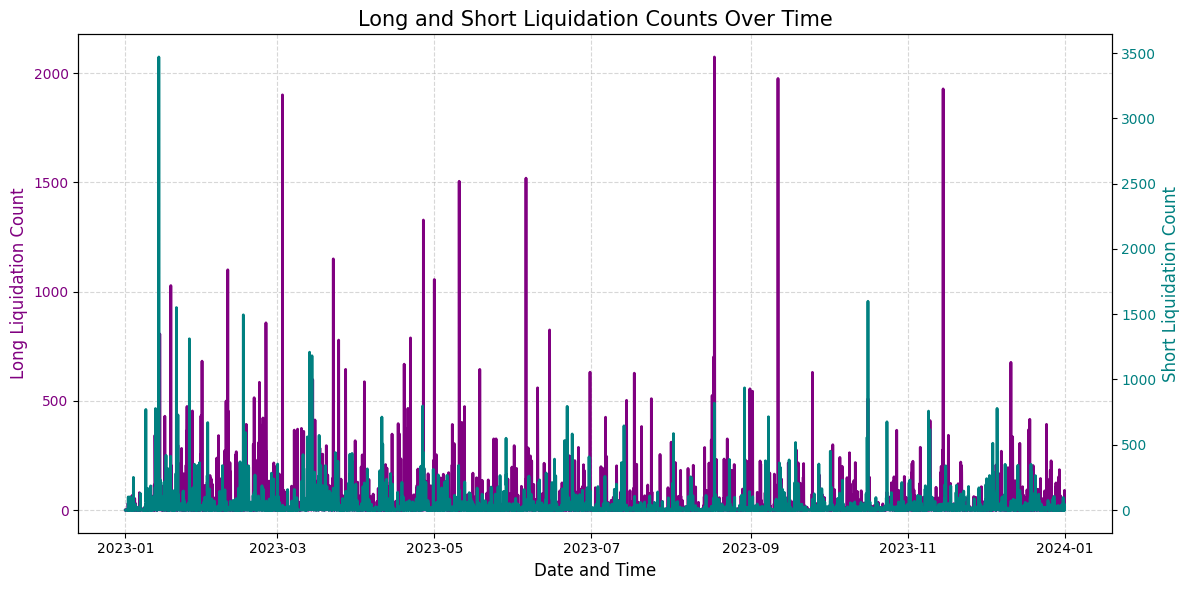

In [42]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(eda_subset['ID'], eda_subset['long_liq_count'], color='purple', label='Long Liquidation Count', linewidth=2)
ax1.set_xlabel('Date and Time', fontsize=12)
ax1.set_ylabel('Long Liquidation Count', color='purple', fontsize=12)
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(eda_subset['ID'], eda_subset['short_liq_count'], color='teal', label='Short Liquidation Count', linewidth=2)
ax2.set_ylabel('Short Liquidation Count', color='teal', fontsize=12)
ax2.tick_params(axis='y', labelcolor='teal')

plt.title('Long and Short Liquidation Counts Over Time', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Date - Liquidation USD

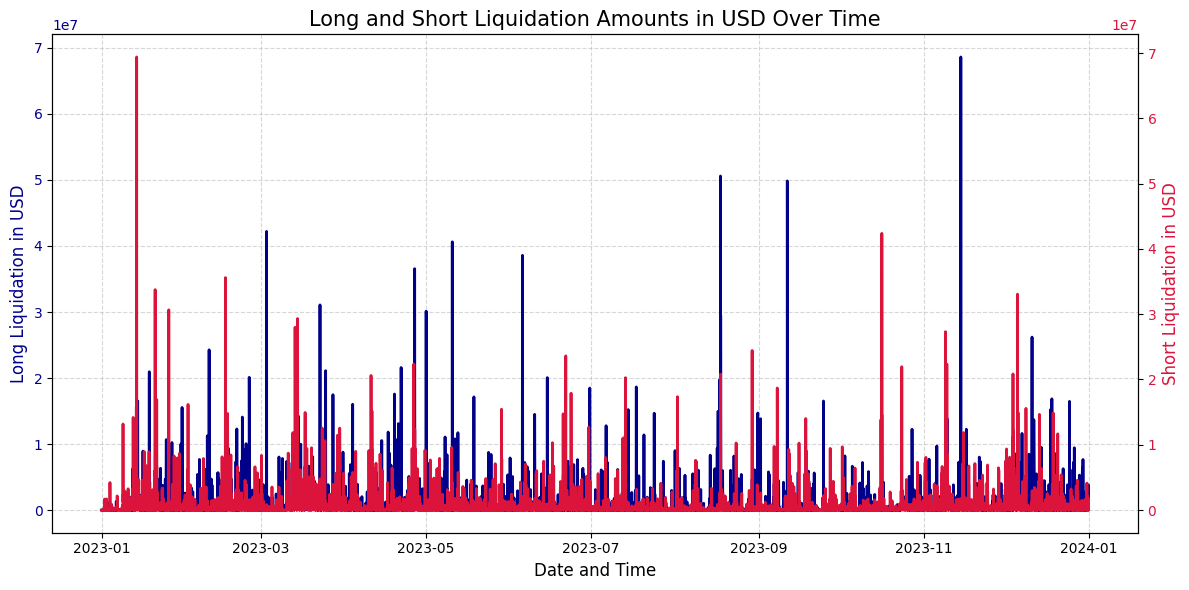

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(eda_subset['ID'], eda_subset['long_liq_usd'], color='darkblue', label='Long Liquidation USD', linewidth=2)
ax1.set_xlabel('Date and Time', fontsize=12)
ax1.set_ylabel('Long Liquidation in USD', color='darkblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(eda_subset['ID'], eda_subset['short_liq_usd'], color='crimson', label='Short Liquidation USD', linewidth=2)
ax2.set_ylabel('Short Liquidation in USD', color='crimson', fontsize=12)
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Long and Short Liquidation Amounts in USD Over Time', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

* Line Plot을는 직관적인 인사이트를 얻기 힘들어 다른 플랏을 더 그려야한다